In [1]:
%run './model/multi_corpus.py'
%run './constants.py'

In [5]:
corpora = co_citation_graphs(n_edges=50)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 43 nodes and 50 edges
Geometry Graph with 37 nodes and 50 edges
Geophysics Graph with 65 nodes and 50 edges
Economics Graph with 43 nodes and 50 edges
Language & Linguistics Graph with 44 nodes and 50 edges
Probability & Statistics Graph with 26 nodes and 50 edges
Material Engineering Graph with 58 nodes and 50 edges
Artificial Intelligence Graph with 48 nodes and 50 edges
Sociology Graph with 39 nodes and 50 edges
International Business Graph with 34 nodes and 50 edges
Political Science Graph with 69 nodes and 50 edges
Genetics & Genomics Graph with 14 nodes and 50 edges
Immunology Graph with 62 nodes and 50 edges
Human Resources & Organizations Graph with 54 nodes and 50 edges
Ethnic & Cultural Studies Graph with 64 nodes and 50 edges
Neurology Graph with 33 nodes and 50 edges


# Co-Citation Graphs

Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


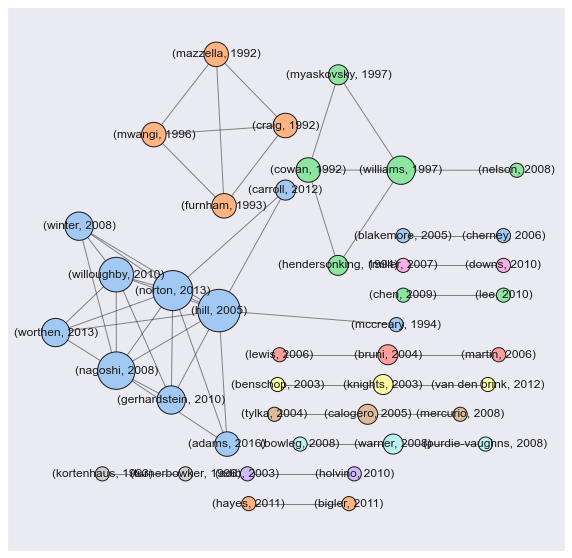

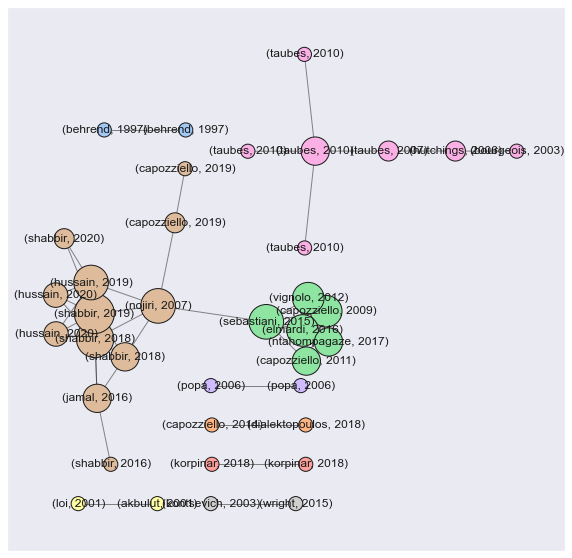

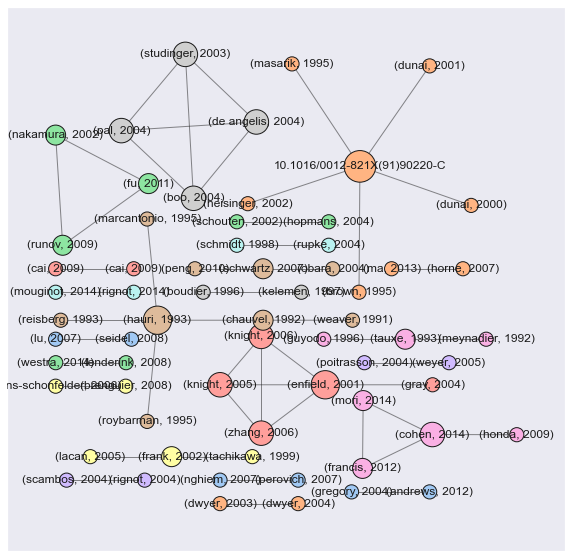

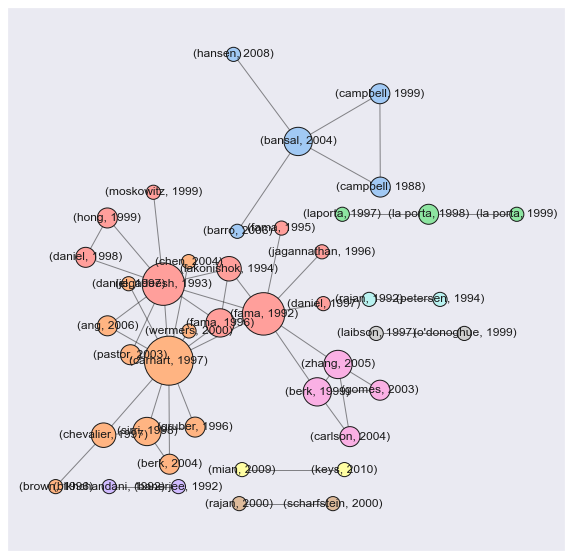

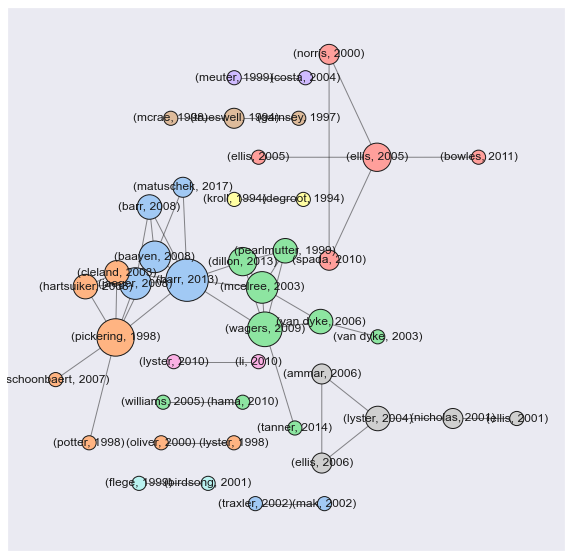

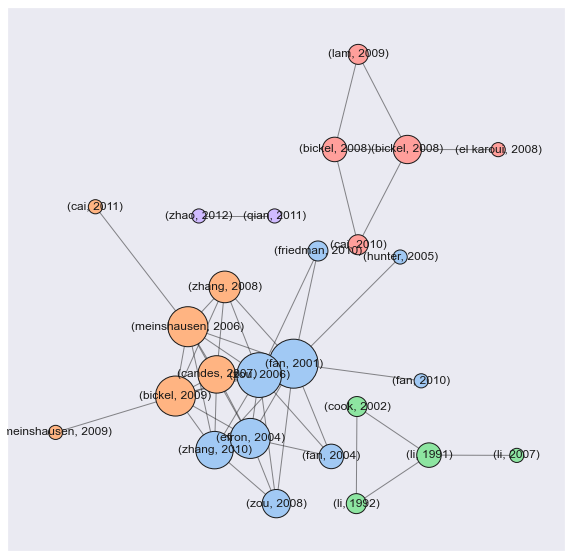

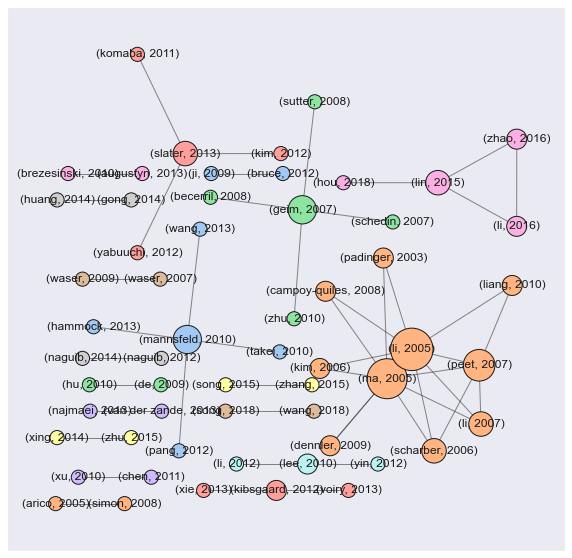

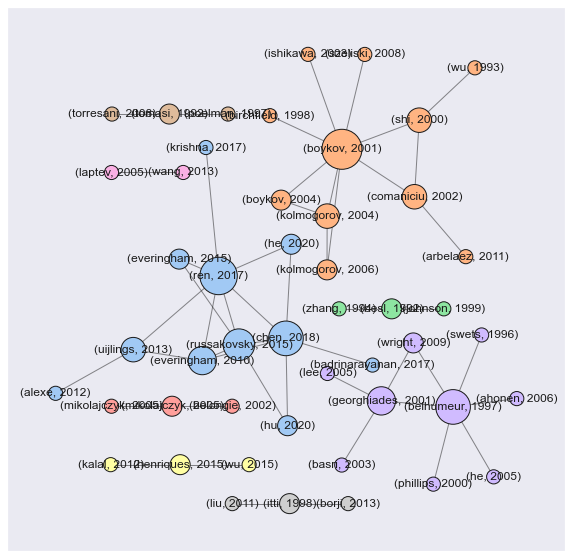

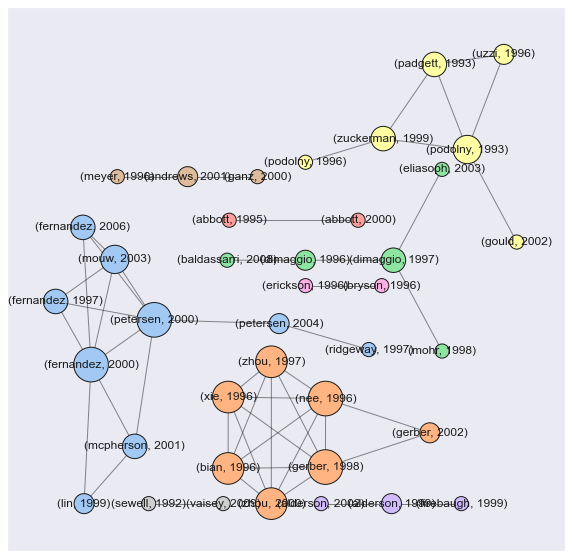

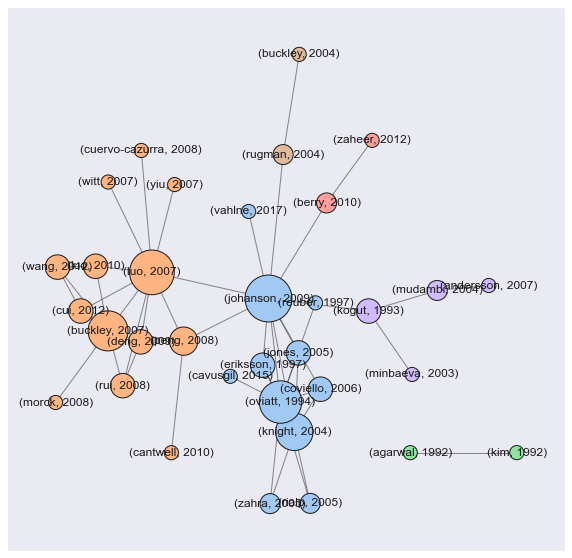

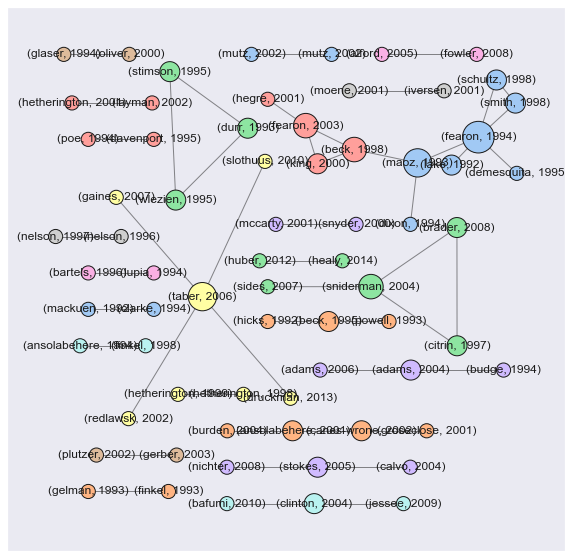

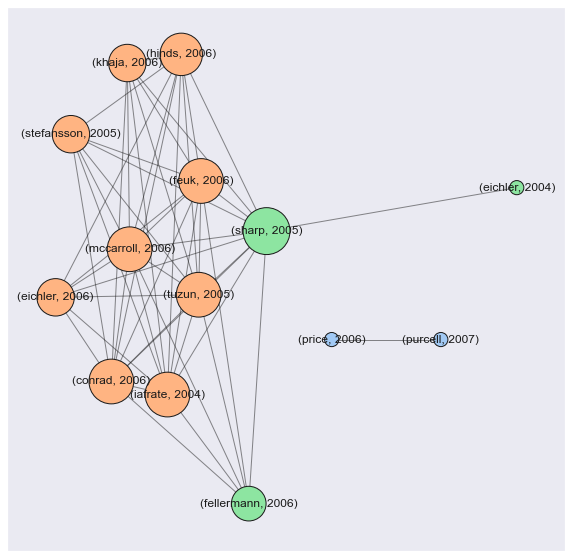

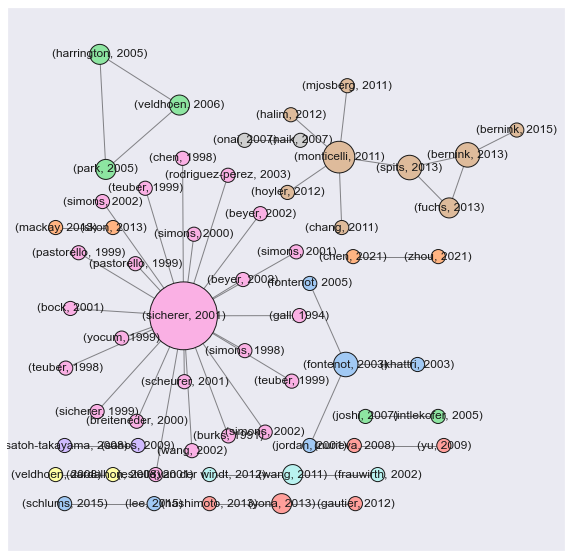

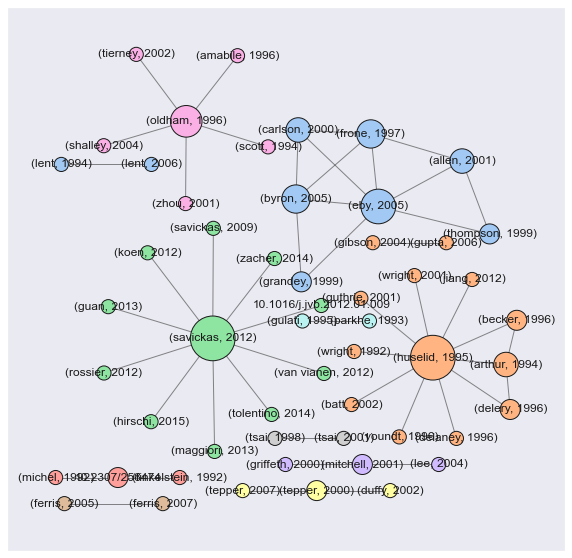

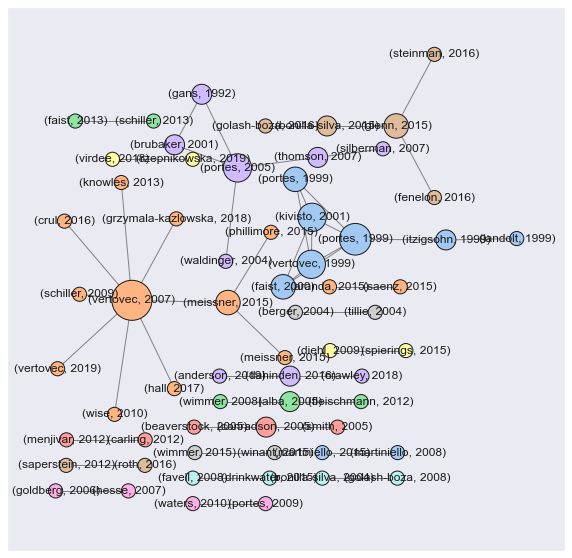

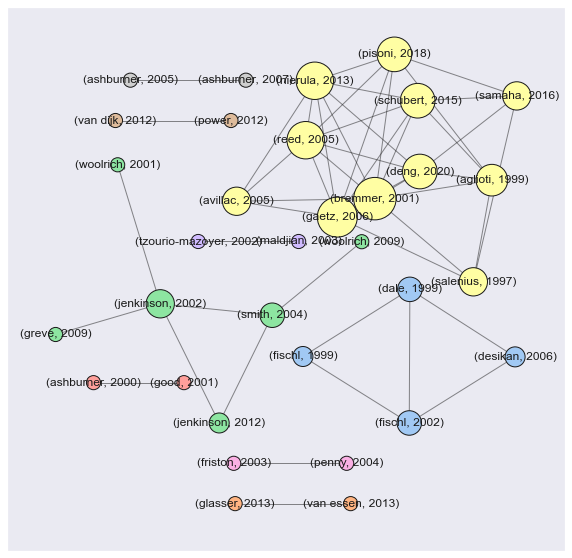

In [8]:
sns.reset_defaults()

co_citation=True
communities=True

for (field_name, G) in Gs.items():

    print(field_name)

    fig, ax = plt.subplots(1, figsize=(10, 10))

    node_deg = dict(nx.degree(G))
    node_names = list(node_deg.keys())
    node_sizes = list(map(lambda deg: deg*200, node_deg.values()))
    node_labels = dict(zip(node_names, node_names))

    new_node_labels = (
        pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
        .select(
            pl.col('Doi'), 
            pl.concat_str([
                pl.lit('('),
                pl.col('Authors').arr.first().str.split(', ').arr.first(),
                pl.lit(', '),
                pl.col('Date').dt.year(),
                pl.lit(')')
            ])
        )
        .filter(pl.col('Doi').is_in(node_names))
        .to_numpy()
    )

    new_node_labels = dict(map(tuple, new_node_labels))
    if co_citation:
        node_labels.update(new_node_labels)

    if communities:
        comms = nx_comm.louvain_communities(G)
        palette = sns.color_palette("pastel", len(comms))
        node_color_map = {}
        for comm, color in zip(comms, palette):
            for node in comm:
                node_color_map[node] = color
        node_color = [node_color_map[n] for n in G.nodes]
        node_color

    pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # dot, twopi, fdp, sfdp, circo

    nx.draw_networkx_nodes(
        G, 
        pos,
        nodelist=node_names,
        node_size=node_sizes,
        # node_color='#00ABB3',
        node_color=node_color,
        node_shape='o',
        alpha=None,
        cmap=plt.cm.Blues,
        ax=ax,
        linewidths=1.0,
        edgecolors='k',
    ).set_zorder(1)

    nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=node_labels)

    nx.draw_networkx_edges(
        G, 
        pos,
        width=1.0,
        edge_color='k',
        style='solid',
        alpha=0.5,
        arrowsize=10,
        ax=ax,
        nodelist=node_names,
        node_size=node_sizes,
        node_shape='o',
        connectionstyle='arc3',
    ).set_zorder(-1)

    ax.grid(False)

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_citation_graphs', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=300 
    )

# Full Co-Citation Graphs

In [2]:
corpora = co_citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 439 nodes and 810 edges
Geometry Graph with 298 nodes and 388 edges
Geophysics Graph with 16305 nodes and 82952 edges
Economics Graph with 4278 nodes and 53161 edges
Language & Linguistics Graph with 1270 nodes and 7819 edges
Probability & Statistics Graph with 1805 nodes and 8151 edges
Material Engineering Graph with 19577 nodes and 213117 edges
Artificial Intelligence Graph with 1897 nodes and 9012 edges
Sociology Graph with 2327 nodes and 21230 edges
International Business Graph with 2667 nodes and 39483 edges
Political Science Graph with 2442 nodes and 13314 edges
Genetics & Genomics Graph with 9323 nodes and 55121 edges
Immunology Graph with 12636 nodes and 190468 edges
Human Resources & Organizations Graph with 3063 nodes and 24554 edges
Ethnic & Cultural Studies Graph with 310 nodes and 506 edges
Neurology Graph with 18589 nodes and 270528 edges


Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


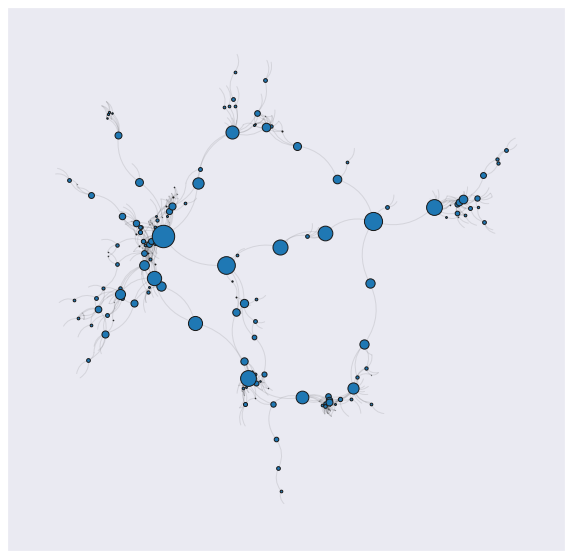

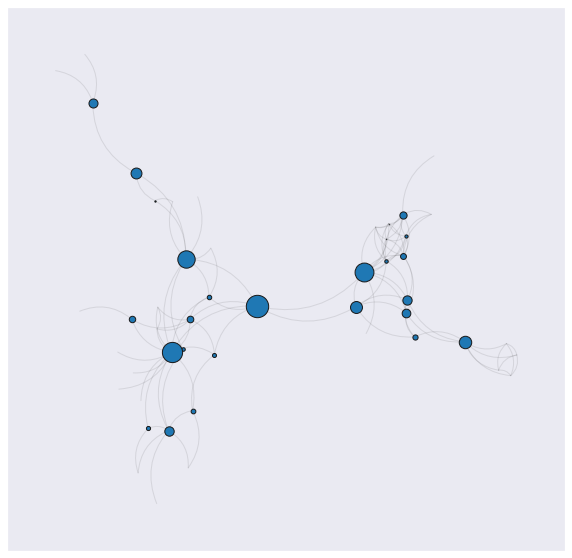

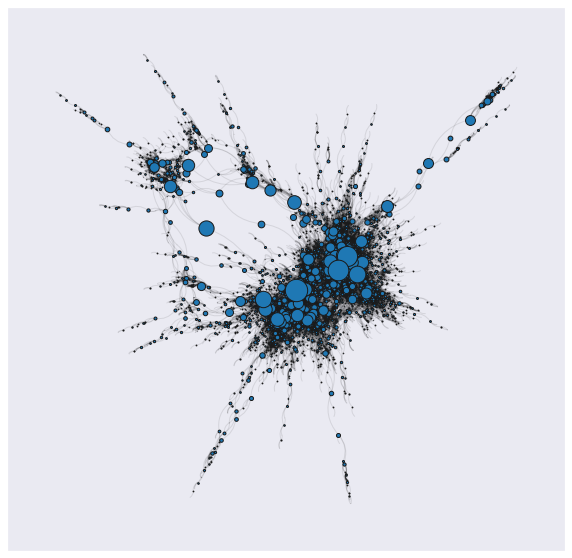

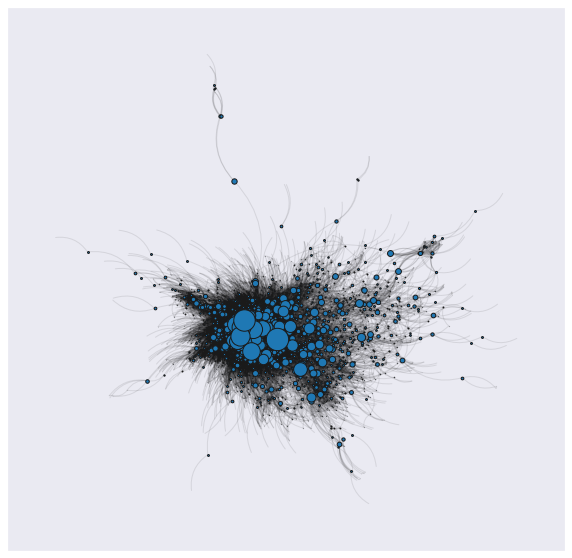

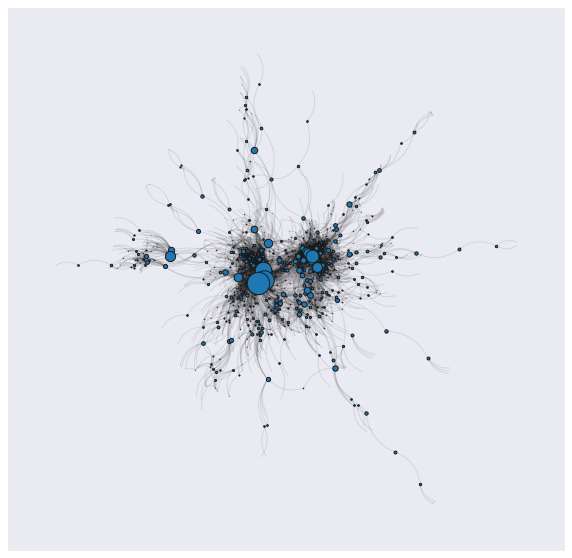

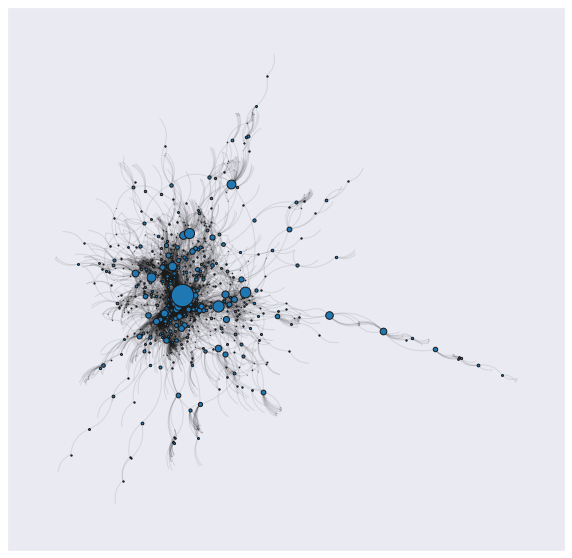

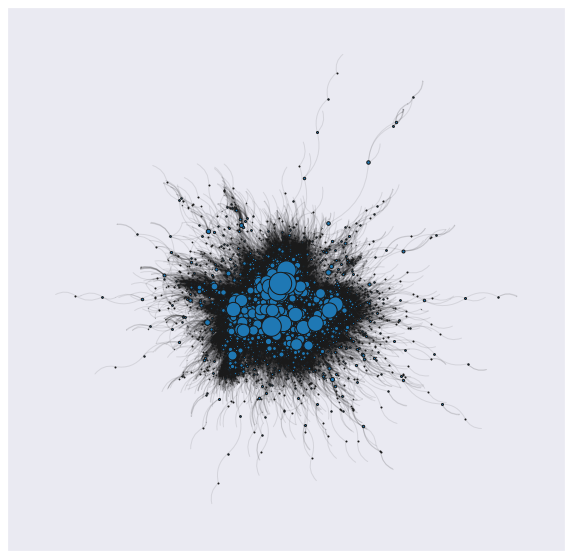

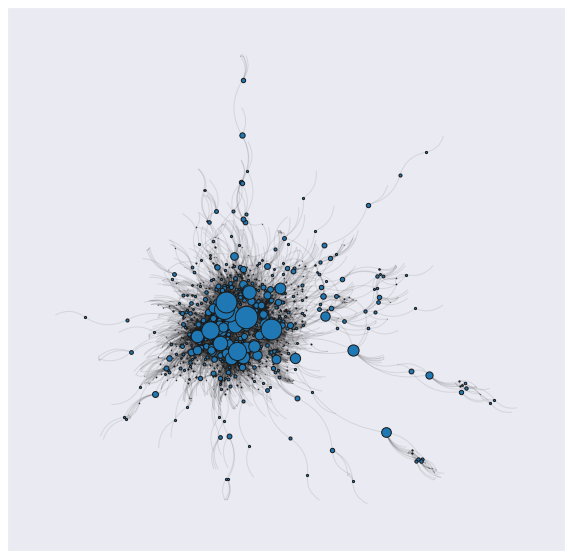

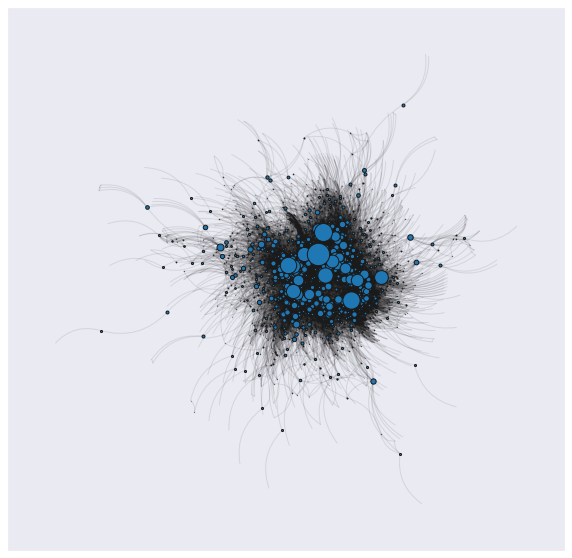

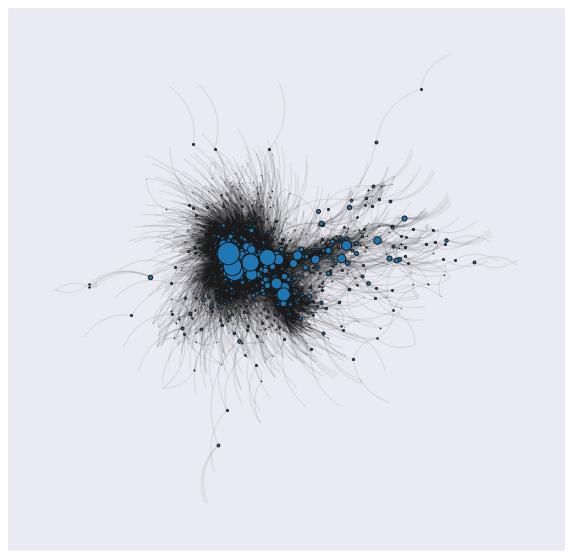

In [4]:
from matplotlib import cm

cmap = cm.plasma
node_factor = 500
# n_cols = 2
# n_rows = np.ceil(len(corpora) / n_cols)

sns.set()

for field_name, G in Gs.items():
    fig, ax = plt.subplots(1, figsize=(10, 10))

    print(field_name)

    G = G.to_undirected()
    G = G.subgraph(max(nx.connected_components(G), key=len))
    cent_map = dict(nx.betweenness_centrality(G))

    sorted_cent_map = dict(sorted(cent_map.items(), key=lambda tup: tup[1]))
    node_list = list(sorted_cent_map.keys())
    node_cent = np.fromiter(sorted_cent_map.values(), float)
    normalized_node_map = dict(zip(node_list, node_cent / node_cent.max()))
    normalized_node_list = list(normalized_node_map.keys())
    normalized_node_cent = np.fromiter(normalized_node_map.values(), float)

    pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp") # dot, twopi, fdp, sfdp, circo

    for i, (node, cent) in enumerate(normalized_node_map.items()):
        greater_nodes = nx.draw_networkx_nodes(
            G, 
            pos, 
            nodelist=[node],
            node_size=[cent * node_factor],
            # node_color=[cent],
            node_shape='o',
            alpha=1,
            ax=ax,
            cmap=cmap,
            linewidths=1,
            edgecolors='k',
            margins=None,
        ) 
        greater_nodes.set_zorder(i)

    edges = nx.draw_networkx_edges(
        G, 
        pos,
        width=1.0,
        edge_color='k',
        style='solid',
        alpha=0.1, 
        ax=ax,
        arrows=True,
        nodelist=node_list,
        node_size=node_cent * node_factor,
        node_shape='o',
        connectionstyle='arc3, rad=0.3',
    )

    # edges.set_zorder(-1)
    for c in edges:
        c.set_zorder(-1)

    ax.grid(False)

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_citation_full_graphs', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=150 
    )

# HeatMap

In [2]:
corpora = co_citation_graphs(n_edges=50)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 53 nodes and 50 edges
Geometry Graph with 47 nodes and 50 edges
Geophysics Graph with 69 nodes and 50 edges
Economics Graph with 41 nodes and 50 edges
Language & Linguistics Graph with 43 nodes and 50 edges
Probability & Statistics Graph with 26 nodes and 50 edges
Material Engineering Graph with 48 nodes and 50 edges
Artificial Intelligence Graph with 48 nodes and 50 edges
Sociology Graph with 39 nodes and 50 edges
International Business Graph with 39 nodes and 50 edges
Political Science Graph with 77 nodes and 50 edges
Genetics & Genomics Graph with 32 nodes and 50 edges
Immunology Graph with 65 nodes and 50 edges
Human Resources & Organizations Graph with 51 nodes and 50 edges
Ethnic & Cultural Studies Graph with 51 nodes and 50 edges
Neurology Graph with 48 nodes and 50 edges


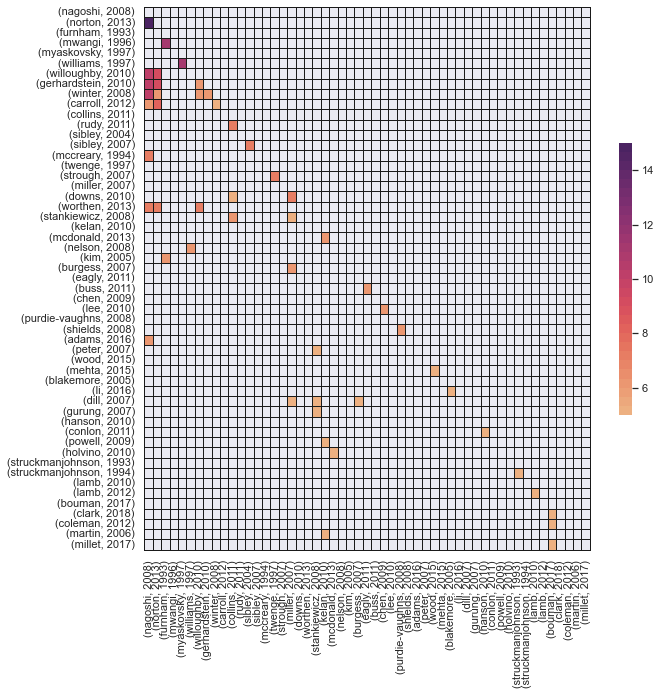

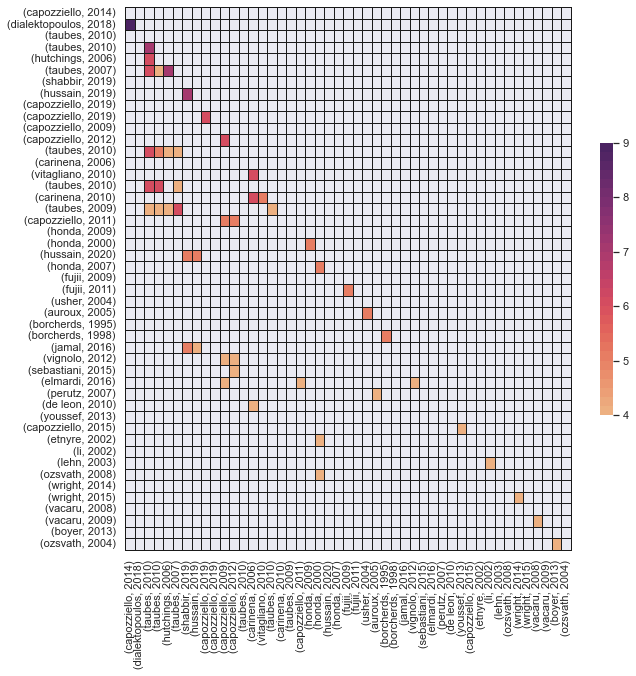

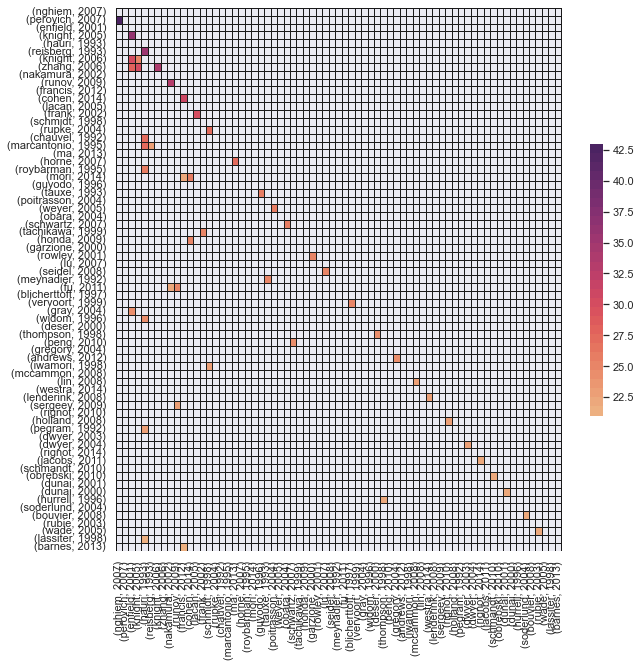

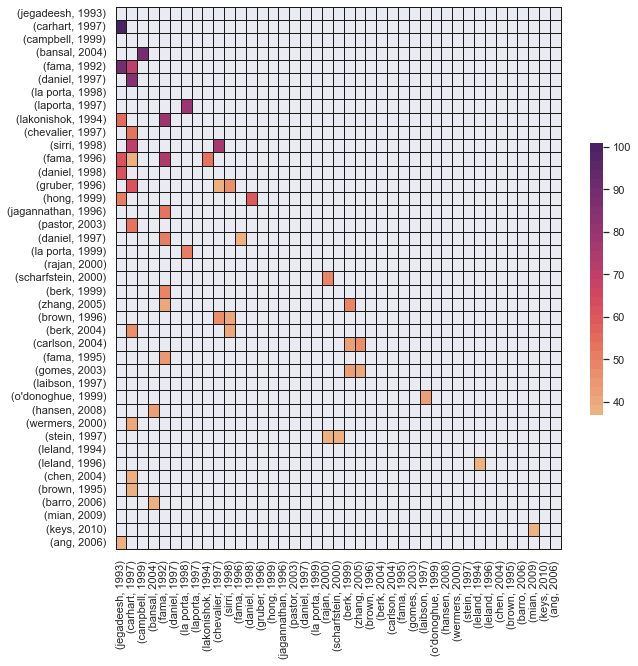

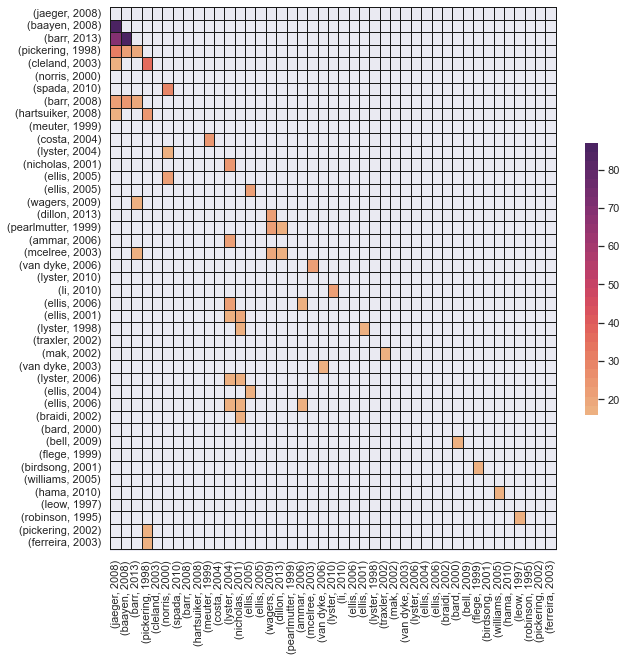

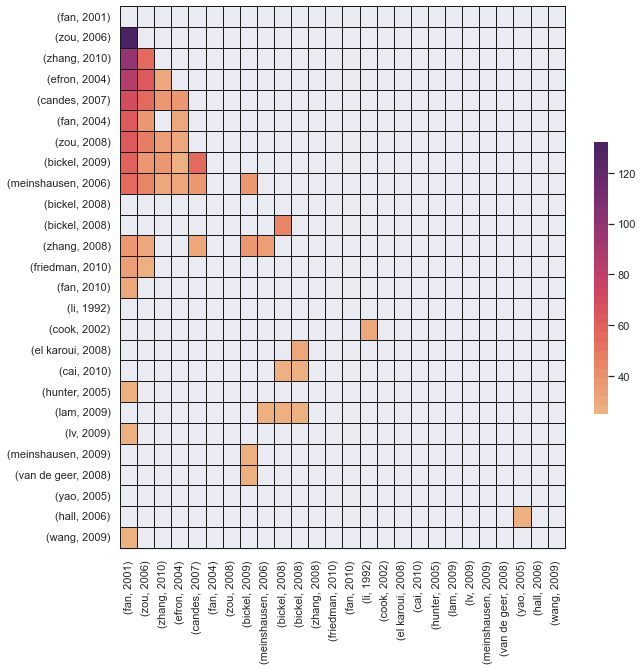

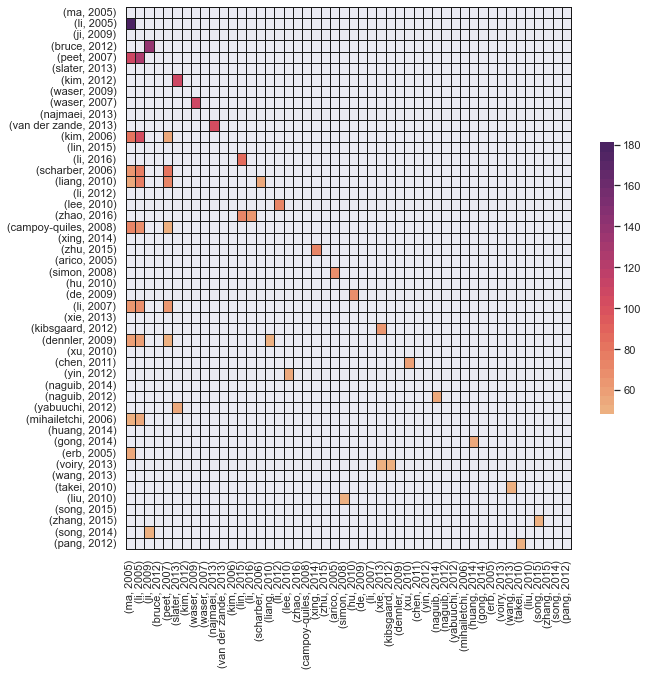

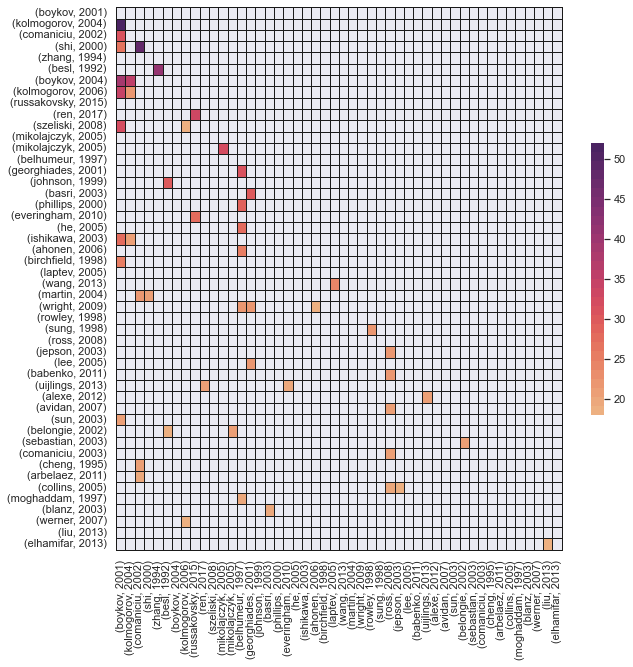

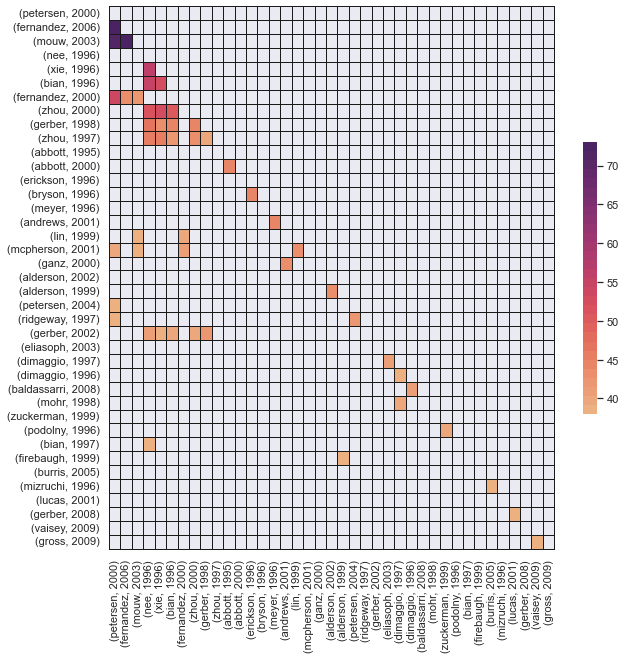

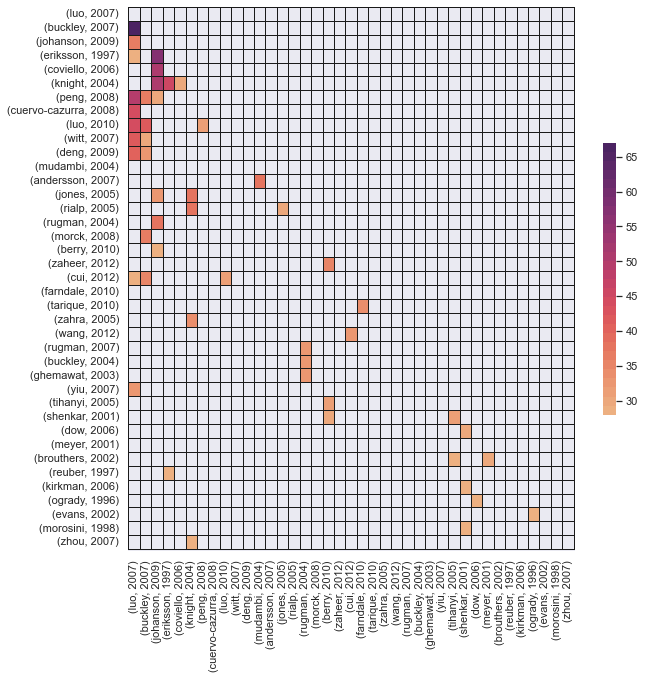

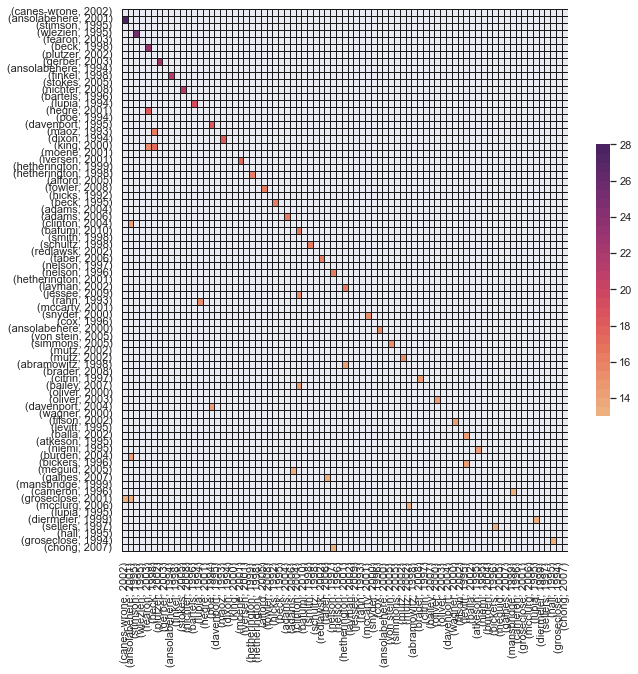

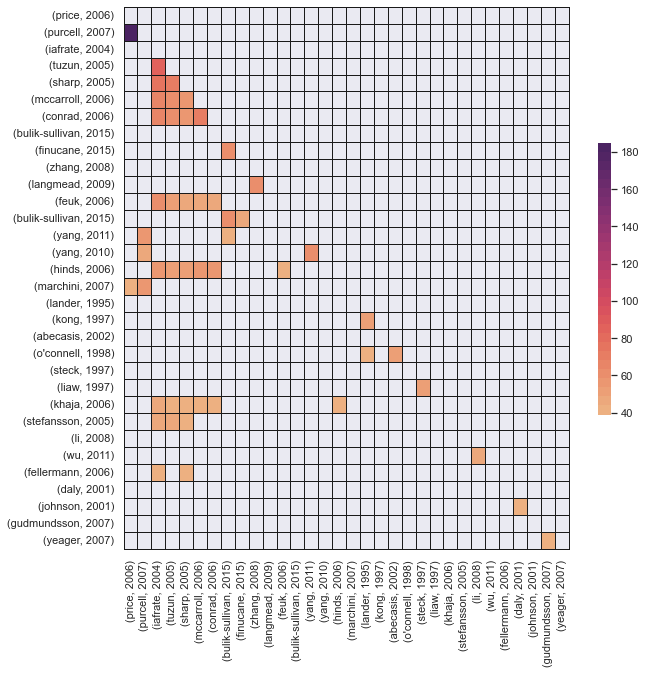

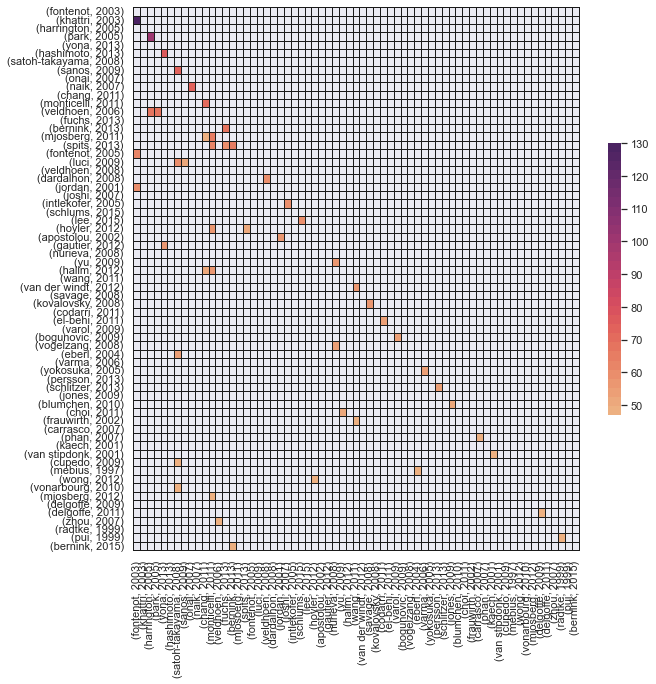

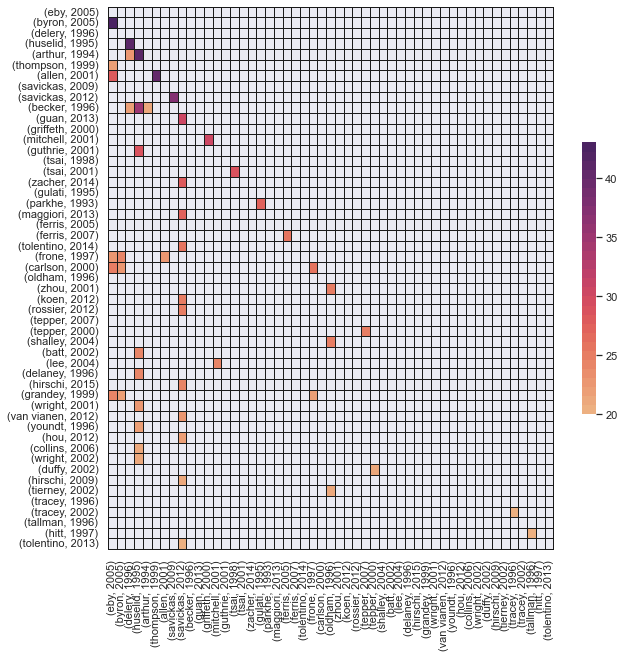

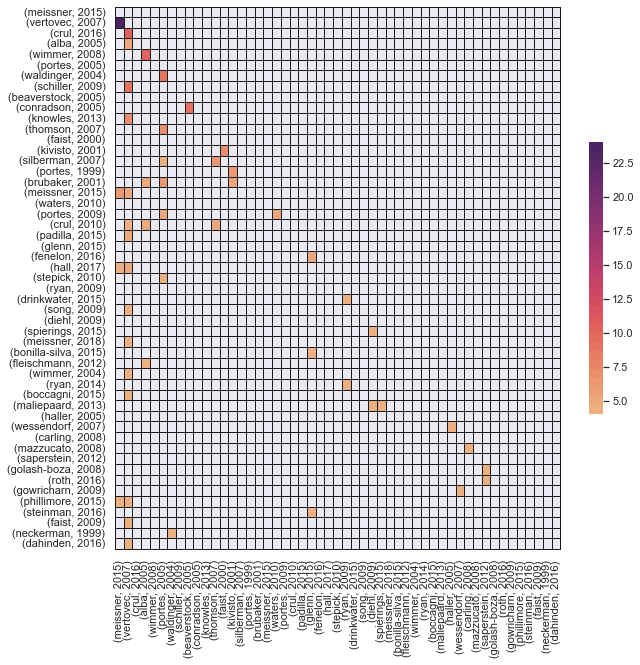

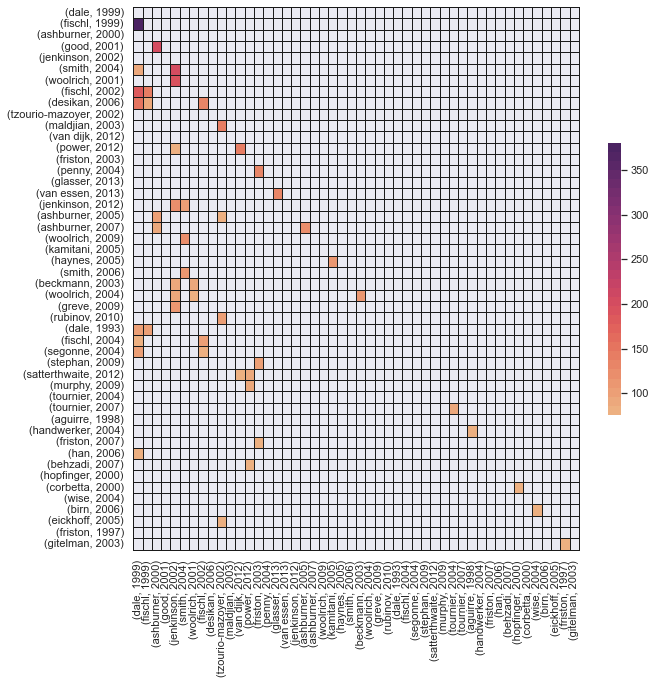

In [5]:

for (field_name, G) in Gs.items():

    fig, ax = plt.subplots(1, figsize=(10, 10))

    nodes = list(G.nodes)

    new_labels = dict(
        pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
        .select(
            pl.col('Doi'), 
            pl.concat_str([
                pl.lit('('),
                pl.col('Authors').arr.first().str.split(', ').arr.first(),
                pl.lit(', '),
                pl.col('Date').dt.year(),
                pl.lit(')')
            ])
        )
        .filter(pl.col('Doi').is_in(nodes))
        .to_numpy()
    )

    labels = dict(zip(nodes, nodes))
    labels.update(new_labels)
    labels = list(labels.values())

    am = nx.to_numpy_array(G)
    up_triang = np.triu(np.ones_like(am)).astype(bool)
    cmap = plt.get_cmap('flare',30)
    cmap.set_under('white')
    cmap.set_over('yellow')

    sns.heatmap(am, linewidth=.5, cmap=cmap, linecolor='k', linewidths=0.5, xticklabels=labels, yticklabels=labels, mask=(am==0) | (up_triang), ax=ax, cbar_kws={"shrink": 0.5})

    ax.set_xlim(0, len(G) + 0.1)
    ax.set_ylim(len(G) + 0.1, 0)

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_citation_heatmap', f'{field_name.capitalize()}.png'), 
        transparent=True,
        dpi=150
    )

# 5 min